<a href="https://colab.research.google.com/github/vdrobin1/first/blob/main/lstmColbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Colbert**

in this code we will use the data from Colbert to try lstm. We will use the PRCP, Tmin, and tmax as features to predict Water Levels since studies suggest that this model doesn't work accurately with only one feature.

DO NOT

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/Summer21

/content/drive/MyDrive/Summer21


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [5]:
Colbert=pd.DataFrame(pd.read_csv("ColbertDailyM.csv"))

In [6]:
Colbert

,Unnamed: 0,DATE,Daily_WL,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DAPR,MDPR,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,YEAR
0,0,2010-12-09,7.667000,USW00063894,"MUSCLE SHOALS 2 N, AL US",34.7728,-87.6399,161.5,0.0,0.0,0.00,0.0,0.0,0.0,45.0,15.0,2010
1,1,2010-12-10,12.844167,USW00063894,"MUSCLE SHOALS 2 N, AL US",34.7728,-87.6399,161.5,0.0,0.0,0.00,0.0,0.0,0.0,47.0,24.0,2010
2,2,2010-12-11,12.733333,USW00063894,"MUSCLE SHOALS 2 N, AL US",34.7728,-87.6399,161.5,0.0,0.0,1.03,0.0,0.0,0.0,52.0,44.0,2010
3,3,2010-12-12,12.078333,USW00063894,"MUSCLE SHOALS 2 N, AL US",34.7728,-87.6399,161.5,0.0,0.0,0.00,0.0,0.0,0.0,44.0,22.0,2010
4,4,2010-12-13,12.189167,USW00063894,"MUSCLE SHOALS 2 N, AL US",34.7728,-87.6399,161.5,0.0,0.0,0.00,0.0,0.0,0.0,29.0,15.0,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3273,3273,2020-05-01,10.940833,USW00063894,"MUSCLE SHOALS 2 N, AL US",34.7728,-87.6399,161.5,0.0,0.0,0.00,0.0,0.0,0.0,76.0,42.0,2020
3274,3274,2020-05-02,11.065833,USW00063894,"MUSCLE SHOALS 2 N, AL US",34.7728,-87.6399,161.5,0.0,0.0,0.00,0.0,0.0,0.0,82.0,50.0,2020
3275,3275,2020-05-03,11.179167,USW00063894,"MUSCLE SHOALS 2 N, AL US",34.7728,-87.6399,161.5,0.0,0.0,0.00,0.0,0.0,0.0,84.0,58.0,2020
3276,3276,2020-05-04,11.290833,USW00063894,"MUSCLE SHOALS 2 N, AL US",34.7728,-87.6399,161.5,0.0,0.0,0.16,0.0,0.0,0.0,81.0,60.0,2020


## **Part 1**

In [7]:
# Importing Training Set
dataset_train = Colbert[['DATE', 'Daily_WL', 'PRCP','TMAX','TMIN']].copy()

In [8]:
#import scipy.stats as stats
#dataset_train['Daily_WL']=dataset_train[['Daily_WL']].apply(stats.zscore)

In [9]:
dataset_train.head()

,DATE,Daily_WL,PRCP,TMAX,TMIN
0,2010-12-09,7.667000,0.00,45.0,15.0
1,2010-12-10,12.844167,0.00,47.0,24.0
2,2010-12-11,12.733333,1.03,52.0,44.0
3,2010-12-12,12.078333,0.00,44.0,22.0
4,2010-12-13,12.189167,0.00,29.0,15.0


In [64]:
print(dataset_train['Daily_WL'].max())
print(dataset_train['Daily_WL'].min())

24.145
0.0


In [10]:

# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:5]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['DATE'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (3278, 5)
All timestamps == 3278
Featured selected: ['Daily_WL', 'PRCP', 'TMAX', 'TMIN']


In [11]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.to_numpy()

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (3278, 4).


array([[ 7.667     ,  0.        , 45.        , 15.        ],
       [12.84416667,  0.        , 47.        , 24.        ],
       [12.73333333,  1.03      , 52.        , 44.        ],
       ...,
       [11.17916667,  0.        , 84.        , 58.        ],
       [11.29083333,  0.16      , 81.        , 60.        ],
       [11.4       ,  0.        , 73.        , 54.        ]])

In [12]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-1.7001745 ],
       [ 0.05059308],
       [ 0.01311246],
       ...,
       [-0.51246162],
       [-0.4746992 ],
       [-0.4377822 ]])

In [13]:
training_set_scaled

array([[-1.7001745 , -0.36079956, -1.57399333, -2.17106984],
       [ 0.05059308, -0.36079956, -1.45569573, -1.61426041],
       [ 0.01311246,  2.01488933, -1.15995171, -0.37690612],
       ...,
       [-0.51246162, -0.36079956,  0.73281001,  0.48924188],
       [-0.4746992 ,  0.00823949,  0.5553636 ,  0.61297731],
       [-0.4377822 , -0.36079956,  0.08217317,  0.24177103]])

In [14]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 7   # Number of days we want top predict into the future
n_past =  30    # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (3242, 30, 3).
y_train shape == (3242, 1).


In [15]:
X_train

array([[[-1.7001745 , -0.36079956, -1.57399333],
        [ 0.05059308, -0.36079956, -1.45569573],
        [ 0.01311246,  2.01488933, -1.15995171],
        ...,
        [-0.74185428,  0.42340842, -1.81058855],
        [-0.7303001 , -0.36079956, -1.39654692],
        [-0.68859235, -0.36079956, -0.80505888]],

       [[ 0.05059308, -0.36079956, -1.45569573],
        [ 0.01311246,  2.01488933, -1.15995171],
        [-0.20838954, -0.36079956, -1.63314214],
        ...,
        [-0.7303001 , -0.36079956, -1.39654692],
        [-0.68859235, -0.36079956, -0.80505888],
        [-0.61391292, -0.36079956, -1.86973735]],

       [[ 0.01311246,  2.01488933, -1.15995171],
        [-0.20838954, -0.36079956, -1.63314214],
        [-0.17090892, -0.36079956, -2.52037419],
        ...,
        [-0.68859235, -0.36079956, -0.80505888],
        [-0.61391292, -0.36079956, -1.86973735],
        [-0.54148797,  0.65405783, -2.28377898]],

       ...,

       [[-1.29166395,  0.10049925,  0.67366121],
        [-1

In [16]:
y_train

array([[-0.39072007],
       [-0.38282941],
       [-0.37691142],
       ...,
       [-0.51246162],
       [-0.4746992 ],
       [-0.4377822 ]])

### **PART 2**

In [17]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow import keras
from tensorflow.keras import layers
#from keras.layers import Adam

In [18]:
dataset_train

,Daily_WL,PRCP,TMAX,TMIN
0,7.667000,0.00,45.0,15.0
1,12.844167,0.00,47.0,24.0
2,12.733333,1.03,52.0,44.0
3,12.078333,0.00,44.0,22.0
4,12.189167,0.00,29.0,15.0
...,...,...,...,...
3273,10.940833,0.00,76.0,42.0
3274,11.065833,0.00,82.0,50.0
3275,11.179167,0.00,84.0,58.0
3276,11.290833,0.16,81.0,60.0


In [19]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')
#model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [20]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 0.3868
Epoch 1: val_loss improved from inf to 0.22427, saving model to weights.h5
11/11 [==============================] - 14s 407ms/step - loss: 0.3868 - val_loss: 0.2243 - lr: 0.0100
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.2084
Epoch 2: val_loss improved from 0.22427 to 0.22163, saving model to weights.h5
11/11 [==============================] - 2s 181ms/step - loss: 0.2084 - val_loss: 0.2216 - lr: 0.0100
Epoch 3/30
10/11 [==========================>...] - ETA: 0s - loss: 0.1949
Epoch 3: val_loss improved from 0.22163 to 0.16534, saving model to weights.h5
11/11 [==============================] - 2s 151ms/step - loss: 0.1937 - val_loss: 0.1653 - lr: 0.0100
Epoch 4/30
11/11 [==============================] - ETA: 0s - loss: 0.1880
Epoch 4: val_loss improved from 0.16534 to 0.15443, saving model to weights.h5
11/11 [==============================] - 2s 163ms/step - loss: 0.1880 - val_loss:

## **PART 3**

In [21]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [22]:
datelist_future

[Timestamp('2020-05-05 00:00:00', freq='D'),
 Timestamp('2020-05-06 00:00:00', freq='D'),
 Timestamp('2020-05-07 00:00:00', freq='D'),
 Timestamp('2020-05-08 00:00:00', freq='D'),
 Timestamp('2020-05-09 00:00:00', freq='D'),
 Timestamp('2020-05-10 00:00:00', freq='D'),
 Timestamp('2020-05-11 00:00:00', freq='D')]

In [23]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [24]:
predictions_future

array([[-0.83419263],
       [-0.9193045 ],
       [-0.8650129 ],
       [-0.81582123],
       [-0.72608376],
       [-0.6672085 ],
       [-0.6084154 ]], dtype=float32)

In [25]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Daily_WL']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Daily_WL']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,Daily_WL
2011-02-13,10.880315
2011-02-14,10.976138
2011-02-15,11.097801


In [26]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


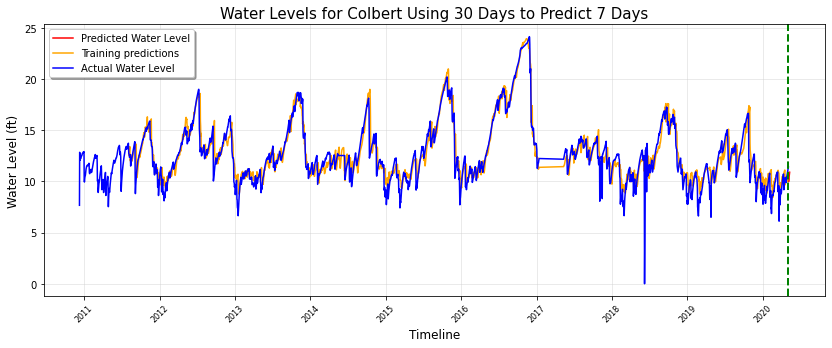

In [27]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters

START_DATE_FOR_PLOTTING = '2011-08-05'
START_DATE_FOR_PLOTTING2 = '2010-12-09'

test_Cole30=plt.figure()

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Daily_WL'], color='r', label='Predicted Water Level')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Daily_WL'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING2:].index, dataset_train.loc[START_DATE_FOR_PLOTTING2:]['Daily_WL'], color='b', label='Actual Water Level')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Water Levels for Colbert Using 30 Days to Predict 7 Days', family='Arial', fontsize=15)
plt.xlabel('Timeline', family='Arial', fontsize=12)
plt.ylabel('Water Level (ft)', family='Arial', fontsize=12)
plt.xticks(rotation=45, fontsize=8)

test_Cole30.show()

In [28]:
test_Cole30.savefig('test_Cole30.png', bbox_inches='tight')

In [29]:
PREDICTION_TRAIN

,Daily_WL
2011-02-13,10.880315
2011-02-14,10.976138
2011-02-15,11.097801
2011-02-16,11.175706
2011-02-17,11.269062
...,...
2020-05-01,10.136643
2020-05-02,10.282107
2020-05-03,10.547468
2020-05-04,10.721567


In [30]:
PREDICTIONS_FUTURE

,Daily_WL
2020-05-05,10.227781
2020-05-06,9.976098
2020-05-07,10.136643
2020-05-08,10.282107
2020-05-09,10.547468
2020-05-10,10.721567
2020-05-11,10.895423


In [31]:
PREDICTIONS_FUTURE=PREDICTIONS_FUTURE.reset_index()
PREDICTIONS_FUTURE=PREDICTIONS_FUTURE.rename(columns={'index':'DATE'})
PREDICTIONS_FUTURE

,DATE,Daily_WL
0,2020-05-05,10.227781
1,2020-05-06,9.976098
2,2020-05-07,10.136643
3,2020-05-08,10.282107
4,2020-05-09,10.547468
5,2020-05-10,10.721567
6,2020-05-11,10.895423


In [32]:
PREDICTION_TRAIN=PREDICTION_TRAIN.reset_index()
PREDICTION_TRAIN=PREDICTION_TRAIN.rename(columns={'index':'DATE'})
PREDICTION_TRAIN

,DATE,Daily_WL
0,2011-02-13,10.880315
1,2011-02-14,10.976138
2,2011-02-15,11.097801
3,2011-02-16,11.175706
4,2011-02-17,11.269062
...,...,...
3207,2020-05-01,10.136643
3208,2020-05-02,10.282107
3209,2020-05-03,10.547468
3210,2020-05-04,10.721567


In [33]:
PREDICTION_TRAIN['DATE']= pd.to_datetime(PREDICTION_TRAIN['DATE'])
PREDICTIONS_FUTURE['DATE']=pd.to_datetime(PREDICTIONS_FUTURE['DATE'])

In [34]:
#Colbert['Daily_WL']=Colbert[['Daily_WL']].apply(stats.zscore)
colb = Colbert[['DATE', 'Daily_WL', 'PRCP']].copy()

In [35]:
colb['DATE']= pd.to_datetime(colb['DATE'])

In [36]:
colb

,DATE,Daily_WL,PRCP
0,2010-12-09,7.667000,0.00
1,2010-12-10,12.844167,0.00
2,2010-12-11,12.733333,1.03
3,2010-12-12,12.078333,0.00
4,2010-12-13,12.189167,0.00
...,...,...,...
3273,2020-05-01,10.940833,0.00
3274,2020-05-02,11.065833,0.00
3275,2020-05-03,11.179167,0.00
3276,2020-05-04,11.290833,0.16


In [37]:
error=pd.merge(colb,PREDICTION_TRAIN, on='DATE')
error

,DATE,Daily_WL_x,PRCP,Daily_WL_y
0,2011-02-13,11.693333,0.00,10.880315
1,2011-02-14,11.799167,0.00,10.976138
2,2011-02-15,11.920000,0.00,11.097801
3,2011-02-16,12.013333,0.00,11.175706
4,2011-02-17,12.102500,0.00,11.269062
...,...,...,...,...
3207,2020-05-01,10.940833,0.00,10.136643
3208,2020-05-02,11.065833,0.00,10.282107
3209,2020-05-03,11.179167,0.00,10.547468
3210,2020-05-04,11.290833,0.16,10.721567


In [38]:
error=error.rename(columns={'Daily_WL_x':'Actual', 'Daily_WL_y':'Prediction'})

In [39]:
error

,DATE,Actual,PRCP,Prediction
0,2011-02-13,11.693333,0.00,10.880315
1,2011-02-14,11.799167,0.00,10.976138
2,2011-02-15,11.920000,0.00,11.097801
3,2011-02-16,12.013333,0.00,11.175706
4,2011-02-17,12.102500,0.00,11.269062
...,...,...,...,...
3207,2020-05-01,10.940833,0.00,10.136643
3208,2020-05-02,11.065833,0.00,10.282107
3209,2020-05-03,11.179167,0.00,10.547468
3210,2020-05-04,11.290833,0.16,10.721567


In [40]:
error=error.drop(columns=['PRCP'])
error

,DATE,Actual,Prediction
0,2011-02-13,11.693333,10.880315
1,2011-02-14,11.799167,10.976138
2,2011-02-15,11.920000,11.097801
3,2011-02-16,12.013333,11.175706
4,2011-02-17,12.102500,11.269062
...,...,...,...
3207,2020-05-01,10.940833,10.136643
3208,2020-05-02,11.065833,10.282107
3209,2020-05-03,11.179167,10.547468
3210,2020-05-04,11.290833,10.721567


In [41]:
error['ERROR']=abs(error['Actual']-error['Prediction'])
error

,DATE,Actual,Prediction,ERROR
0,2011-02-13,11.693333,10.880315,0.813019
1,2011-02-14,11.799167,10.976138,0.823029
2,2011-02-15,11.920000,11.097801,0.822199
3,2011-02-16,12.013333,11.175706,0.837627
4,2011-02-17,12.102500,11.269062,0.833438
...,...,...,...,...
3207,2020-05-01,10.940833,10.136643,0.804190
3208,2020-05-02,11.065833,10.282107,0.783726
3209,2020-05-03,11.179167,10.547468,0.631698
3210,2020-05-04,11.290833,10.721567,0.569266


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


slope b1 is 0.8857736485692934
intercept b0 is 1.6111787326291491


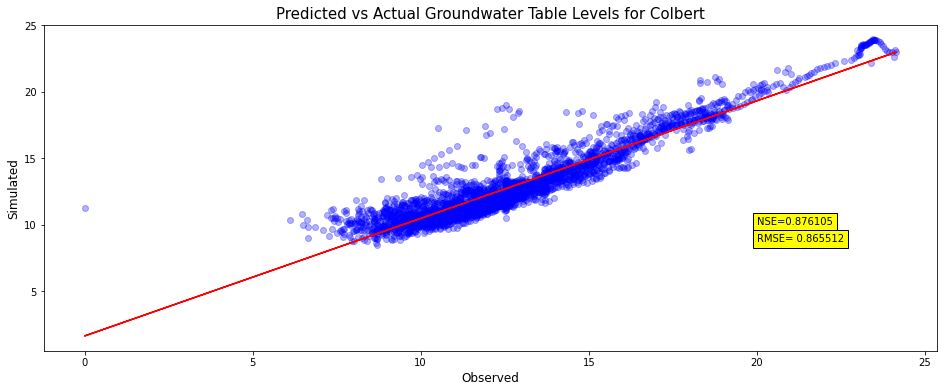

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

graph2_Colb=plt.figure(figsize=(16, 6))

x=np.array(error['Actual'])
y=np.array(error['Prediction'])

n = np.size(x)
  
x_mean = np.mean(x)
y_mean = np.mean(y)
x_mean,y_mean
  
Sxy = np.sum(x*y)- n*x_mean*y_mean
Sxx = np.sum(x*x)-n*x_mean*x_mean
  
b1 = Sxy/Sxx
b0 = y_mean-b1*x_mean
print('slope b1 is', b1)
print('intercept b0 is', b0)
  
#plt.scatter(x,y)
#plt.xlabel('Independent variable X')
#plt.ylabel('Dependent variable y')

y_pred = b1 * x + b0
  
plt.scatter(x, y, color = 'blue', alpha=0.3)
plt.plot(x, y_pred, color = 'red')
plt.xlabel('Observed',fontsize=12,ha='center')
plt.ylabel('Simulated',fontsize=12,ha='center')
plt.text(20,10,'NSE=0.876105',bbox={"fc":"yellow"})
plt.text(20,8.7,'RMSE= 0.865512',bbox={"fc":"yellow"})

plt.title("Predicted vs Actual Groundwater Table Levels for Colbert",fontsize=15,ha='center')
graph2_Colb.savefig('graph2_Colb.png',dpi=400,bbox_inches='tight')

In [43]:
#Calculate NSE https://agrimetsoft.com/calculators/Nash%20Sutcliffe%20model%20Efficiency%20coefficient
a1=np.array(error['Actual']) 
a2=np.array(error['Prediction']) 
denominator = np.sum((a1 - np.mean(a1)) ** 2)
numerator = np.sum((a2 - a1) ** 2)
nse_val = 1 - numerator / denominator
print(nse_val)

0.8720368364180437


In [44]:
x = x.reshape(-1,1)
regression_model = LinearRegression()
  
# Fit the data(train the model)
regression_model.fit(x, y)
  
# Predict
y_predicted = regression_model.predict(x)
  
# model evaluation
mse=mean_squared_error(y,y_predicted)
  
rmse = np.sqrt(mean_squared_error(y, y_predicted))
r2 = r2_score(y, y_predicted)


# printing values
print('Slope:',regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('MSE:',mse)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [0.8857732]
Intercept: 1.6111847061547788
MSE: 0.995263512007055
Root mean squared error:  0.997628945052746
R2 score:  0.8749974331462981


0.0007652791341126175
11.2427978515625


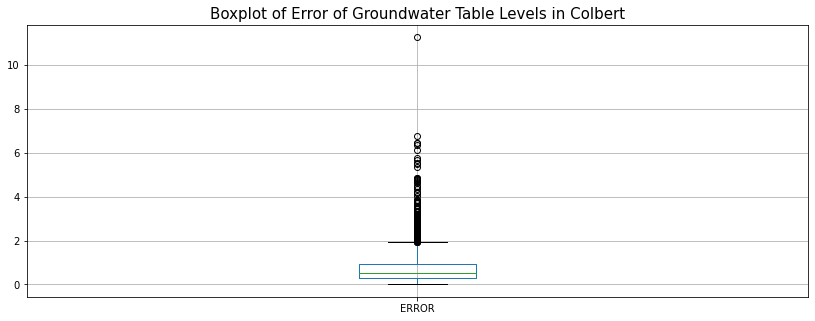

In [59]:
fig100 = plt.figure()
plt.title("Boxplot of Error of Groundwater Table Levels in Colbert", fontsize=15,ha='center')
error_MAD=error.boxplot(column=['ERROR'], return_type='axes')
fig100.savefig('boxplot1_Colb.png',dpi=400,bbox_inches='tight')
print(error['ERROR'].min())
print(error['ERROR'].max())

In [46]:
error.describe()

,Actual,Prediction,ERROR
count,3212.000000,3212.000000,3212.000000
mean,12.717891,12.876358,0.742570
std,2.980287,2.822132,0.764853
min,0.000000,8.427983,0.000765
25%,10.690625,10.898526,0.272183
50%,12.259167,12.077012,0.529006
75%,13.993333,13.938936,0.941538
max,24.145000,23.947050,11.242798


In [47]:
error.to_csv('Colbert30.csv') 

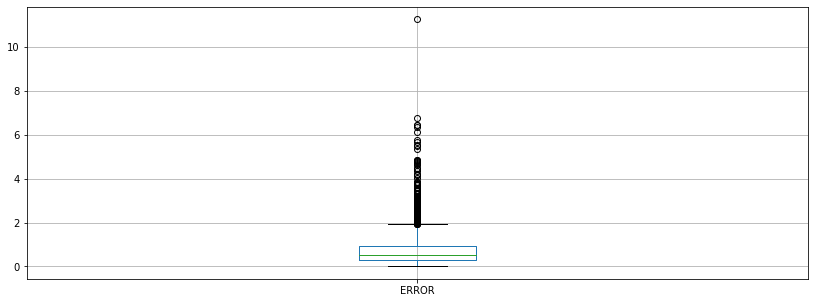

In [48]:
error.boxplot(column=['ERROR'], return_type='axes')

In [49]:
error['ERROR'].min()

0.0007652791341126175

In [50]:
error['ERROR'].max()

11.2427978515625

In [51]:
error['ERROR'].median()

0.5290056927998847

In [52]:
error['ERROR'].mean()

0.7425703910431908

In [53]:
error.to_csv('Error_Colbert.csv')

In [54]:
PREDICTIONS_FUTURE.to_csv('FUTURE_Colbert.csv')

I wanted to do a t test on different variables to test the strength of them with respect to water level.

In [55]:
#pip install pingouin --upgrade

In [56]:
#import pandas_flavor as pf
#from itertools import combinations, product
#from pingouin.config import options
#from pingouin.parametric import anova
#from pingouin.multicomp import multicomp
#from pingouin.effsize import compute_effsize, convert_effsize
#from pingouin.utils import (_check_dataframe, _flatten_list, _postprocess_dataframe)
#from scipy.stats import studentized_range

In [57]:
import pingouin

ModuleNotFoundError: ignored

In [ ]:
Colbert['PRCP'].mean()

In [ ]:
stats_WL = pingouin.ttest(Colbert['Daily_WL'], Colbert['TMAX'], paired=False, alternative='two-sided')
stats_WL

In [ ]:
look_back = 500
std_part = 2.0  # use values from 0 to 1 if you have an idea what part of STD should be used.
test2_Cole30=plt.figure(figsize=(16, 6))
ax1 = plt.subplot(211)
act_lb = error['Prediction']
pred_lb = error['Actual']
err_std = error['ERROR'].std(axis=0)
err_mean = error['ERROR'].mean(axis=0)
pred_upper = pred_lb + err_mean + err_std * std_part
pred_lower = pred_lb + err_mean - err_std * std_part
err_x = np.linspace(0, len(act_lb)-1, len(act_lb))
plt.plot(error['Actual'], label='Actual Water Level ')
plt.plot(error['Prediction'], label='Predicted Water Level')
plt.fill_between(x=err_x, y1=pred_upper, y2=pred_lower, color='green', lw=2, alpha=0.2)
plt.legend()
plt.grid()
plt.title('Confidence Interval for Colbert', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Water Level', family='Arial', fontsize=10)


test2_Cole30.show()

In [ ]:
test2_Cole30.savefig('CI_Cole30.png')

In [ ]:
x_values = Colbert['Daily_WL']
y_values = Colbert['PRCP']

correlation_matrix = np.corrcoef(x_values, y_values)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(r_squared)

In [ ]:
x_values = Colbert['Daily_WL']
y_values = Colbert['TMAX']

correlation_matrix = np.corrcoef(x_values, y_values)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(r_squared)

In [ ]:
x_values = Colbert['Daily_WL']
y_values = Colbert['TMIN']

correlation_matrix = np.corrcoef(x_values, y_values)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(r_squared)